In [ ]:
import gc
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, Image, ClassLabel
from transformers import Trainer, TrainingArguments, DefaultDataCollator, ViTForImageClassification
import torch
from torch import nn
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, RandomHorizontalFlip

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [ ]:
from pathlib import Path
import os
from tqdm import tqdm

# Load file paths and labels
file_names = []
labels = []

for file in sorted((Path('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)
    file_names.append(str(file))

print(len(file_names), len(labels))

# Create a pandas DataFrame
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

120000 120000
(120000, 2)


In [6]:
df['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [7]:
# Perform oversampling
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
df['label'] = y_resampled
gc.collect()

print(df.shape)

(120000, 2)


In [8]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

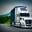

In [ ]:
dataset[0]["image"]

In [11]:
labels_list = ['REAL', 'FAKE']  # Predefined labels
label2id, id2label = {}, {}
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label


In [12]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [13]:
# Define CNN Image Processor
cnn_input_size = (224, 224)
cnn_image_mean = [0.485, 0.456, 0.406]
cnn_image_std = [0.229, 0.224, 0.225]

_train_transforms = Compose([
    Resize(cnn_input_size),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=cnn_image_mean, std=cnn_image_std)
])

_val_transforms = Compose([
    Resize(cnn_input_size),
    ToTensor(),
    Normalize(mean=cnn_image_mean, std=cnn_image_std)
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [14]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [15]:
# Data Collator
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Define CNN Feature Extractor
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 28 * 28, 256)  # Adjusted for 224x224 input

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class WeightedFusionModel(nn.Module):
    def __init__(self, num_labels):
        super(WeightedFusionModel, self).__init__()
        self.cnn = CNNFeatureExtractor()
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k", num_labels=num_labels
        )
        self.weight_cnn = nn.Parameter(torch.tensor(0.5))  # Learnable weight for CNN
        self.weight_vit = nn.Parameter(torch.tensor(0.5))  # Learnable weight for ViT
        self.fc = nn.Linear(256 + 768, num_labels)  
        self.criterion = nn.CrossEntropyLoss()  # Loss function

    def forward(self, pixel_values, labels=None):
        # Pass inputs through CNN
        cnn_features = self.cnn(pixel_values)

        # Pass inputs through ViT
        vit_output = self.vit(pixel_values, output_hidden_states=True)
        vit_features = vit_output.hidden_states[-1][:, 0, :]  # CLS token from ViT

        # Concatenate features
        combined_features = torch.cat(
            (self.weight_cnn * cnn_features, self.weight_vit * vit_features), dim=1
        )

        # Classification layer
        logits = self.fc(combined_features)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.criterion(logits, labels)

        return {"loss": loss, "logits": logits}



# Initialize the Weighted Fusion Model
num_labels = len(labels_list)
model = WeightedFusionModel(num_labels)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 111585862


In [ ]:
# Training arguments
args = TrainingArguments(
    output_dir="vit",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    tokenizer=None,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, p.predictions.argmax(axis=1))
    }
)

In [18]:
# Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.033600,0.038760,0.990500


TrainOutput(global_step=6750, training_loss=0.08079897124679, metrics={'train_runtime': 3200.7825, 'train_samples_per_second': 33.742, 'train_steps_per_second': 2.109, 'total_flos': 0.0, 'train_loss': 0.08079897124679, 'epoch': 1.0})

In [19]:
# Predict on test data
outputs = trainer.predict(test_data)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

Classification Report:
              precision    recall  f1-score   support

        REAL     0.9900    0.9910    0.9905      6000
        FAKE     0.9910    0.9900    0.9905      6000

    accuracy                         0.9905     12000
   macro avg     0.9905    0.9905    0.9905     12000
weighted avg     0.9905    0.9905    0.9905     12000



In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on test data
outputs = trainer.predict(test_data)

# Extract predictions and true labels
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9905
Precision: 0.9905
Recall: 0.9905
F1 Score: 0.9905


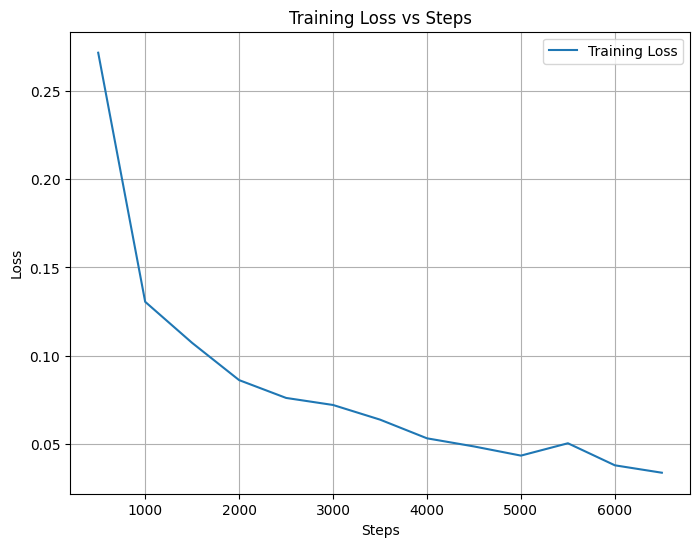

In [21]:
# Extract and plot training loss
training_loss = trainer.state.log_history

losses = [log['loss'] for log in training_loss if 'loss' in log]
steps = [log['step'] for log in training_loss if 'loss' in log]

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.grid(True)
plt.show()


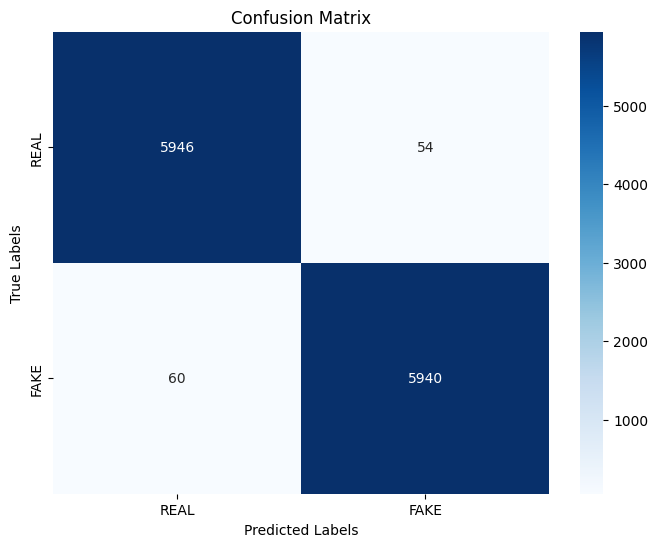

In [22]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = labels_list

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
